# Movie recommendation on Amazon SageMaker with Neural Networks and MXNet

### Step SM1: Download ml-100k data  
***The data sets are needed to train our Neural Network. We use the 100,000 movie ratings given by users from MovieLens data sets.***

#####  The data sets are needed to train our Factorization Machine. We use the 100,000 movie ratings given by users from MovieLens data sets.

In [1]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray

import pandas as pd
import numpy as np

In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
s3_bucket = sess.default_bucket()
s3_prefix = 'movielens'

arn:aws:iam::349934754982:role/service-role/AmazonSageMaker-ExecutionRole-20190123T091078
CPU times: user 491 ms, sys: 35.9 ms, total: 527 ms
Wall time: 545 ms


In [3]:
s3_bucket = sess.default_bucket()
s3_prefix = 'movielens'

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-349934754982


### Data Information
*ua.base : data for training*  
*ua.test : data for test/validation*  
*Headers/columns :* ***user id | item id | rating (1-5) | timestamp***

In [4]:
train_df = pd.read_csv('./ml-100k/ua.base', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
test_df = pd.read_csv('./ml-100k/ua.test', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
pd.set_option('display.max_rows', 5)
train_df

,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,1,1,5,874965758
1,1,2,3,876893171
...,...,...,...,...
90568,943,1228,3,888640275
90569,943,1330,3,888692465


In [5]:
def max_id(fname):
    mu = 0
    mi = 0
    with open(fname) as f:
        for line in f:
            tks = line.strip().split('\t')
            if len(tks) != 4:
                continue
            mu = max(mu, int(tks[0]))
            mi = max(mi, int(tks[1]))
    return mu + 1, mi + 1
max_users, max_items = max_id('./ml-100k/ua.base')
(max_users, max_items)

(944, 1683)

## Prepare data to push to S3

In [29]:
X_train=train_df[['USER_ID','ITEM_ID']].values
y_train=train_df[['RATING']].values

In [30]:
X_test=test_df[['USER_ID','ITEM_ID']].values
y_test=test_df[['RATING']].values

In [31]:
np.save('./data/train/train_X.npy', X_train)
np.save('./data/train/train_Y.npy', y_train)
np.save('./data/test/test_X.npy', X_test)
np.save('./data/test/test_Y.npy', y_test)

In [32]:
traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)
output_s3 = 's3://{}/{}/models/'.format(s3_bucket, s3_prefix)
code_location_s3 = 's3://{}/{}/codes'.format(s3_bucket, s3_prefix)

In [33]:
train_s3 = sess.upload_data(path='./data/train/', bucket=s3_bucket, key_prefix=traindata_s3_prefix)
test_s3 = sess.upload_data(path='./data/test/', bucket=s3_bucket, key_prefix=testdata_s3_prefix)

In [34]:
inputs = {'train':train_s3, 'test': test_s3}

## Network Architecture

In [56]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_latent_factors = 32

We start with a linear model architecture. This is essentially the same exercise as learning two matrices U,I such that UxI = R and we are back to the original Matrix Facotization problem. We have 3 components, user and item embeddings and a final dot product to evaluate our predicted ratings.

In [59]:
def lin_net():
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(max_items, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(max_users, n_latent_factors,name='User-Embedding')(user_input))

    prod = keras.layers.dot([movie_vec, user_vec],axes=1,name='DotProduct')
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    return model

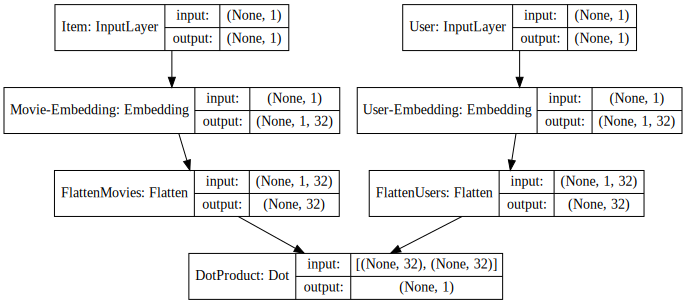

In [60]:
net=lin_net()
SVG(model_to_dot(net,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [128]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(max_items, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(max_users, n_latent_factors,name='User-Embedding')(user_input))
prod = keras.layers.dot([movie_vec, user_vec],axes=1,name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')
    
model.summary()
model.fit([X_train[:,0], X_train[:,1]], y_train, epochs=10, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 32)        53856       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 32)        30208       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


90570/90570 [==============================] - 7s 73us/step - loss: 6.9060
Epoch 2/10
90570/90570 [==============================] - 7s 81us/step - loss: 1.1233
Epoch 3/10
90570/90570 [==============================] - 7s 81us/step - loss: 0.9289
Epoch 4/10
90570/90570 [==============================] - 7s 81us/step - loss: 0.8737
Epoch 5/10
90570/90570 [==============================] - 8s 86us/step - loss: 0.8296
Epoch 6/10
90570/90570 [==============================] - 8s 89us/step - loss: 0.7913
Epoch 7/10
90570/90570 [==============================] - 8s 83us/step - loss: 0.7590
Epoch 8/10
90570/90570 [==============================] - 8s 83us/step - loss: 0.7250
Epoch 9/10
90570/90570 [==============================] - 7s 82us/step - loss: 0.6889
Epoch 10/10
90570/90570 [==============================] - 7s 82us/step - loss: 0.6508


## Train model on Sagemaker

In [51]:
from sagemaker.mxnet import MXNet, MXNetModel

In [91]:
mxnet_estimator = MXNet('keras_rec.py',
                        role=role,
                        train_instance_type='ml.c4.xlarge',
                        train_instance_count=1,
                        framework_version='1.3.0',
                        py_version='py3',
                        hyperparameters={'batch-size': 32,'epochs': 10,'learning-rate': 0.1,'embedding-size':32,'max-users':max_users,'max-items':max_items})
mxnet_estimator.fit(inputs)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-349934754982
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2019-03-04-21-14-24-328


2019-03-04 21:14:24 Starting - Starting the training job...
2019-03-04 21:14:26 Starting - Launching requested ML instances......
2019-03-04 21:15:33 Starting - Preparing the instances for training......
2019-03-04 21:16:53 Downloading - Downloading input data
2019-03-04 21:16:53 Training - Training image download completed. Training in progress..
2019-03-04 21:16:53,522 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-03-04 21:16:53,525 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-04 21:16:53,541 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_INPUT_CONFIG_DIR': '/opt/ml/input/config', 'SM_OUTPUT_DIR': '/opt/ml/output', 'SM_CURRENT_HOST': 'algo-1', 'SM_MODULE_DIR': 's3://sagemaker-us-east-1-349934754982/sagemaker-mxnet-2019-03-04-21-14-24-328/source/sourcedir.tar.gz', 'SM_NUM_GPUS': '0', 'SM_MODULE_NAME': 'keras_rec_nl', 'SM_LOG_LEVEL': '20', 'SM_OUTPUT_INTERMEDIATE_DIR': '/opt

90570/90570 [==============================] - 13s 140us/step - loss: 0.9179
Epoch 2/10

60832/90570 [===================>..........] - ETA: 4s - loss: 0.8993


90570/90570 [==============================] - 14s 154us/step - loss: 0.9034
Epoch 3/10

36032/90570 [==========>...................] - ETA: 8s - loss: 0.9069


90570/90570 [==============================] - 14s 154us/step - loss: 0.9042
Epoch 4/10

10112/90570 [==>...........................] - ETA: 12s - loss: 0.8954


76000/90570 [========================>.....] - ETA: 2s - loss: 0.9041


90570/90570 [==============================] - 14s 152us/step - loss: 0.9043
Epoch 5/10

83296/90570 [==========================>...] - ETA: 1s - loss: 0.9054


90570/90570 [==============================] - 14s 154us/step - loss: 0.9044
Epoch 6/10

90570/90570 [==============================] - 14s 153us/step - loss: 0.9037
Epoch 7/10

32864/90570 [=========>....................] - ETA: 8s - loss: 0.9024


90570/90570 [==============================] - 14s 154us/step - loss: 0.9037
Epoch 8/10

 6880/90570 [=>............................] - ETA: 12s - loss: 0.9307


71584/90570 [======================>.......] - ETA: 2s - loss: 0.9029


90570/90570 [==============================] - 14s 154us/step - loss: 0.9033
Epoch 9/10

46624/90570 [==============>...............] - ETA: 6s - loss: 0.9048


90570/90570 [==============================] - 14s 154us/step - loss: 0.9052
Epoch 10/10

20768/90570 [=====>........................] - ETA: 10s - loss: 0.9023


86208/90570 [===========================>..] - ETA: 0s - loss: 0.9036



2019-03-04 21:19:22 Uploading - Uploading generated training model
2019-03-04 21:19:22 Completed - Training job completed
90570/90570 [==============================] - 14s 154us/step - loss: 0.9030
MXNet Backend: Successfully exported the model as MXNet model!
MXNet symbol file -  /opt/ml/model/model-symbol.json
MXNet params file -  /opt/ml/model/model-0000.params


Model input data_names and data_shapes are: 
data_names :  ['/User1', '/Item1']
data_shapes :  [DataDesc[/User1,(32, 1),float32,NCHW], DataDesc[/Item1,(32, 1),float32,NCHW]]


Note: In the above data_shapes, the first dimension represent the batch_size used for model training. 
You can change the batch_size for binding the module based on your inference batch_size.
2019-03-04 21:19:15,213 sagemaker-containers INFO     Reporting training SUCCESS
Billable seconds: 161


## Deploy model

In [62]:
sagemaker_model = MXNetModel(model_data = 's3://' + s3_bucket + '/model/model.tar.gz',
                             role = role,
                             entry_point = 'keras_rec.py')

In [77]:
predictor = mxnet_estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2019-03-04-20-29-31-652
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2019-03-04-20-29-31-652


----------------------------------------------------------------------------------------------------*

ValueError: Error hosting endpoint sagemaker-mxnet-2019-03-04-20-29-31-652: Failed Reason:  The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint.

## Evaluate

In [ ]:
y_hat = np.round(model.predict([test_df.USER_ID, test_df.ITEM_ID]),0)
y_true = test_df.RATING

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

In [ ]:
sess.delete_endpoint(predictor.endpoint)

## Non-linear Architecture

In [92]:
def nl_net():
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(max_items, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(max_users, n_latent_factors,name='User-Embedding')(user_input))

    concat = keras.layers.concatenate([movie_vec, user_vec],name='Concat')
    concat_dropout = keras.layers.Dropout(0.2)(concat)
    dense = keras.layers.Dense(200,name='FullyConnected', activation='relu')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_2 = keras.layers.Dense(100,name='FullyConnected-1',activation='relu')(concat)
    dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = keras.layers.Dense(50,name='FullyConnected-2', activation='relu')(dense_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)
        
    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model

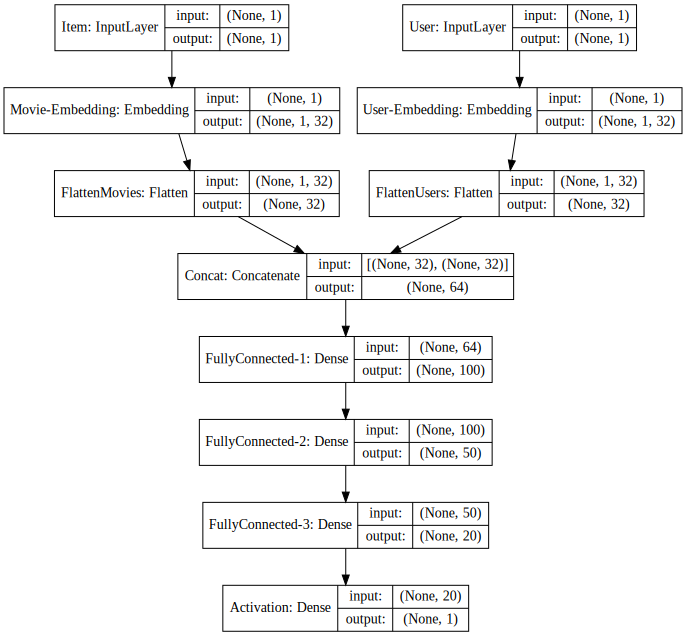

In [93]:
net=nl_net()
SVG(model_to_dot(net,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [ ]:
mxnet_estimator = MXNet('keras_rec_nl.py',
                        role=role,
                        train_instance_type='ml.c4.xlarge',
                        train_instance_count=1,
                        framework_version='1.3.0',
                        py_version='py3',
                        hyperparameters={'batch-size': 32,'epochs': 10,'learning-rate': 0.1,'embedding-size':32,'max-users':max_users,'max-items':max_items})
mxnet_estimator.fit(inputs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 32)        53856       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 32)        30208       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


90570/90570 [==============================] - 7s 72us/step - loss: 6.7910
Epoch 2/10
90570/90570 [==============================] - 7s 81us/step - loss: 1.1181
Epoch 3/10
90570/90570 [==============================] - 9s 99us/step - loss: 0.9344
Epoch 4/10
90570/90570 [==============================] - 7s 81us/step - loss: 0.8898
Epoch 5/10
90570/90570 [==============================] - 7s 81us/step - loss: 0.8568
Epoch 6/10
90570/90570 [==============================] - 7s 82us/step - loss: 0.8240
Epoch 7/10
90570/90570 [==============================] - 7s 81us/step - loss: 0.7880
Epoch 8/10
90570/90570 [==============================] - 7s 82us/step - loss: 0.7522
Epoch 9/10
90570/90570 [==============================] - 7s 81us/step - loss: 0.7152
Epoch 10/10
90570/90570 [==============================] - 7s 82us/step - loss: 0.6748


In [97]:
import keras.models
import json

def save(model, model_prefix='model'):
    print('Saving model in MXNet format')
    data_name, data_shapes = keras.models.save_mxnet_model(model=model, prefix='model', epoch=0)
    signature = [{'name': data_name[0], 'shape': [dim for dim in data_desc.shape]} for data_desc in data_shapes]
    with open('model-shapes.json', 'w') as f:
        json.dump(signature, f)
    return data_shapes

In [98]:
data_shapes=save(model)

Saving model in MXNet format
MXNet Backend: Successfully exported the model as MXNet model!
MXNet symbol file -  model-symbol.json
MXNet params file -  model-0000.params


Model input data_names and data_shapes are: 
data_names :  ['/User18', '/Item18']
data_shapes :  [DataDesc[/User18,(32, 1),float32,NCHW], DataDesc[/Item18,(32, 1),float32,NCHW]]


Note: In the above data_shapes, the first dimension represent the batch_size used for model training. 
You can change the batch_size for binding the module based on your inference batch_size.


In [99]:
ctx = mx.cpu()

In [111]:
data_shapes

[DataDesc[/User18,(32, 1),float32,NCHW],
 DataDesc[/Item18,(32, 1),float32,NCHW]]

In [114]:
sym, arg_params, aux_params = mx.model.load_checkpoint('model', 0)
mod = mx.mod.Module(symbol=sym,data_names=data_name, context=ctx, label_names=None)
mod.bind(for_training=False, data_shapes=data_shapes,
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [120]:
model=mod.load('model', 0, data_names=data_name)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:55: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	/Item18
	Movie-Embedding/embeddings18
	/User18
	User-Embedding/embeddings18
  warnings.warn(msg)


In [127]:
nd_iter = mx.io.NDArrayIter(data={'/User18': mx.nd.array(X_test[0,0]),'/Item18':mx.nd.array(X_test[0,1])},batch_size=1)

ValueError: Shape inconsistent: expected () vs got (1,)

In [121]:
nx.ndarry
mod.forward([X_test[0,0],X_test[0,0]])

AttributeError: 'int' object has no attribute 'shape'

In [ ]:
sagemaker_model = MXNetModel(model_data = '',
                             role = role,
                             entry_point = 'keras_rec.py',
                             py_version='py3')

In [89]:
X_test[:,0]

array([  1,   1,   1, ..., 943, 943, 943])

In [119]:
model.evaluate([X_test[:,0],X_test[:,0]], y_test, batch_size=32)

AttributeError: 'Module' object has no attribute 'evaluate'

In [85]:
net.forward(mx.nd.array([0]),mx.nd.array([1]))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [
[ 0.]
<NDArray 1 @cpu(0)>]...

In [90]:
ratings[0,1]

0.084418066

In [90]:
ratings[0,1]

0.084418066